The report aims to ascertain the variables influencing JWC's high level of attrition, the rate at which employees leave an organisation,  either voluntarily or due to dismissal. A machine learning algorithm will be deployed to determine the priortise the necessary actions for reducing new recruitment.

In [1]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score,classification_report
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Probit
import math

# Data Gathering

The vast majority of the data on employees are stored on a database. Therefore, it is necessary to form connection from Jupyter Notebooke to the database server in order to obtain the relevant data.

In [2]:
connection=psycopg2.connect(user="postgres",password="password",host="localhost",port="5432",database="jwc_db")
employee_data=pd.read_sql("SELECT * FROM employee_survey_data",connection)
general_data=pd.read_sql("SELECT * FROM general_data",connection)
manager_data=pd.read_sql("SELECT * FROM manager_survey_data",connection)

In [3]:
#Check for duplicates
print(len(employee_data["EmployeeID"].unique()))
print(len(general_data["EmployeeID"].unique()))
print(len(manager_data["EmployeeID"].unique()))

4410
4410
4410


There are no duplicates, indicating that each employee is unique across the datasets. Therefore, I can combine the 3 datasets into one using "EmployeeID" as the unique identifier.

In [4]:
df=employee_data.merge(general_data,how="inner",on="EmployeeID").merge(manager_data,how="inner",on="EmployeeID")

In [5]:
df.head()

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,...,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating
0,1,3.0,4.0,2.0,51,No,Travel_Rarely,Sales,6,2,...,11,8,0,1.0,6,1,0,0,3,3
1,2,3.0,2.0,4.0,31,Yes,Travel_Frequently,Research & Development,10,1,...,23,8,1,6.0,3,5,1,4,2,4
2,3,2.0,2.0,1.0,32,No,Travel_Frequently,Research & Development,17,4,...,15,8,3,5.0,2,5,0,3,3,3
3,4,4.0,4.0,3.0,38,No,Non-Travel,Research & Development,2,5,...,11,8,3,13.0,5,8,7,5,2,3
4,5,4.0,1.0,3.0,32,No,Travel_Rarely,Research & Development,10,1,...,12,8,2,9.0,2,6,0,4,3,3


### Create an overtime variable

A potentially useful explanatory variable that may affect the attribution rate is whether an employee works overtime or not. This can be calculated by manipulating the check-in and check-out data.

In [6]:
check_in=pd.read_csv("in_time.csv",index_col=0)
check_out=pd.read_csv("out_time.csv",index_col=0)

In [7]:
print(check_in.shape)
print(check_out.shape)

(4410, 261)
(4410, 261)


In [8]:
check_in.head()
check_out.head()

,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
1,NaN,2015-01-02 16:56:15,2015-01-05 17:20:11,2015-01-06 17:19:05,2015-01-07 16:34:55,2015-01-08 17:08:32,2015-01-09 17:38:29,2015-01-12 16:58:39,2015-01-13 18:02:58,NaN,...,NaN,2015-12-21 17:15:50,2015-12-22 17:27:51,2015-12-23 16:44:44,2015-12-24 17:47:22,NaN,2015-12-28 18:00:07,2015-12-29 17:22:30,2015-12-30 17:40:56,2015-12-31 17:17:33
2,NaN,2015-01-02 18:22:17,2015-01-05 17:48:22,NaN,2015-01-07 17:09:06,2015-01-08 17:34:04,2015-01-09 16:52:29,2015-01-12 17:36:48,2015-01-13 18:00:13,NaN,...,2015-12-18 18:31:28,2015-12-21 17:34:16,2015-12-22 18:16:35,2015-12-23 17:38:18,NaN,NaN,2015-12-28 17:08:38,2015-12-29 17:54:46,2015-12-30 18:31:35,2015-12-31 17:40:58
3,NaN,2015-01-02 16:59:14,2015-01-05 17:06:46,2015-01-06 16:38:32,2015-01-07 16:33:21,2015-01-08 17:24:22,2015-01-09 16:57:30,2015-01-12 17:28:54,2015-01-13 17:21:25,NaN,...,2015-12-18 17:02:23,2015-12-21 17:20:17,2015-12-22 16:32:50,2015-12-23 16:59:43,2015-12-24 16:58:25,NaN,2015-12-28 16:43:31,2015-12-29 17:09:56,2015-12-30 17:06:25,2015-12-31 17:15:50
4,NaN,2015-01-02 17:25:24,2015-01-05 17:14:03,2015-01-06 17:07:42,2015-01-07 16:32:40,2015-01-08 16:53:11,2015-01-09 17:19:47,2015-01-12 17:13:37,2015-01-13 17:11:45,NaN,...,2015-12-18 17:55:23,2015-12-21 16:49:09,2015-12-22 17:24:00,2015-12-23 17:36:35,2015-12-24 16:48:21,NaN,2015-12-28 17:19:34,2015-12-29 16:58:16,2015-12-30 17:40:11,2015-12-31 17:09:14
5,NaN,2015-01-02 18:31:37,2015-01-05 17:49:15,2015-01-06 17:26:25,2015-01-07 17:37:59,2015-01-08 17:59:28,2015-01-09 17:44:08,2015-01-12 18:51:21,2015-01-13 18:14:58,NaN,...,2015-12-18 17:52:48,2015-12-21 17:43:35,2015-12-22 18:07:57,2015-12-23 18:00:49,2015-12-24 17:59:22,NaN,2015-12-28 17:44:59,2015-12-29 18:47:00,2015-12-30 17:15:33,2015-12-31 17:42:14


In [9]:
#Remove all dates when the office is closed.
check_in.dropna(axis=1,how="all",inplace=True)
#If all the employees did not check-in on a particular day, it can be assumed that the office is closed on that day. 
check_out.dropna(axis=1,how="all",inplace=True)

In [10]:
check_in.columns

Index(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
       '2015-01-09', '2015-01-12', '2015-01-13', '2015-01-15', '2015-01-16',
       ...
       '2015-12-17', '2015-12-18', '2015-12-21', '2015-12-22', '2015-12-23',
       '2015-12-24', '2015-12-28', '2015-12-29', '2015-12-30', '2015-12-31'],
      dtype='object', length=249)

In [11]:
#Convert all the dates into datetime objects
all_dates=check_in.columns
check_in[all_dates]=check_in[all_dates].apply(pd.to_datetime)
check_out[all_dates]=check_out[all_dates].apply(pd.to_datetime)

In [12]:
check_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 1 to 4410
Columns: 249 entries, 2015-01-02 to 2015-12-31
dtypes: datetime64[ns](249)
memory usage: 8.4 MB


In [13]:
#Work out the difference and convert the deltatime object into float format
working_hours=(check_out-check_in).applymap(lambda x:(x.total_seconds())/3600)

In [14]:
working_hours.head(2)

,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-15,2015-01-16,...,2015-12-17,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-28,2015-12-29,2015-12-30,2015-12-31
1,7.208333,7.189722,7.410833,7.006667,7.289722,7.484444,7.262778,7.831111,7.346944,7.2675,...,NaN,NaN,7.339167,7.395833,6.504722,7.596389,7.773889,7.3150,7.778889,7.080278
2,8.109167,7.454722,NaN,7.396944,7.416667,7.150833,7.611389,7.278889,7.613056,7.7275,...,7.928333,7.903056,7.753889,7.712222,7.435556,NaN,7.614722,7.9825,7.986111,8.227222


In [15]:
#Work out the average time spent at work for each employee
average_hours_worked=pd.DataFrame(working_hours.mean(axis=1),columns=["hours"])

In [16]:
#Since the standard compulsary is 8, we can create a variable to check if employee works overtime or not on average
average_hours_worked["overtime"]=["Yes" if i>8 else "No" for i in average_hours_worked.hours]

In [17]:
average_hours_worked["EmployeeID"]=average_hours_worked.index

In [18]:
#Join the time data with the original data.
df=df.merge(average_hours_worked,how="inner",on="EmployeeID")

In [19]:
df.head(1)

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,hours,overtime
0,1,3.0,4.0,2.0,51,No,Travel_Rarely,Sales,6,2,...,0,1.0,6,1,0,0,3,3,7.373651,No


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               4410 non-null   int64  
 1   EnvironmentSatisfaction  4385 non-null   float64
 2   JobSatisfaction          4390 non-null   float64
 3   WorkLifeBalance          4372 non-null   float64
 4   Age                      4410 non-null   int64  
 5   Attrition                4410 non-null   object 
 6   BusinessTravel           4410 non-null   object 
 7   Department               4410 non-null   object 
 8   DistanceFromHome         4410 non-null   int64  
 9   Education                4410 non-null   int64  
 10  EducationField           4410 non-null   object 
 11  EmployeeCount            4410 non-null   int64  
 12  Gender                   4410 non-null   object 
 13  JobLevel                 4410 non-null   int64  
 14  JobRole                 

# EDA

In [21]:
#remove irrelevant variables for analysis.
df=df.drop(["EmployeeID","hours","StandardHours","EmployeeCount","JobLevel","StockOptionLevel"],axis=1)
#I've decided to remove JobLevel and StockOptionLevel because the outcomes from these two variables are hard to interpret as it is not specified in the data dictionary.
#Check if there are any employees that are aged below 18
len(df[df["Age"]<18])
df=df.drop(["Over18"],axis=1)

### Ensure each variable has the correct data type

In [22]:
# Modify ordinal variables in accordance to the data dictionary.
df["Education"]=df["Education"].map({1:"Below College",2:"College",3:"Bachelor",4:"Master",5:"Doctor"})
df["EnvironmentSatisfaction"]=df["EnvironmentSatisfaction"].map({1:"Low",2:"Medium",3:"High",4:"Very High"})
df["JobInvolvement"]=df["JobInvolvement"].map({1:"Low",2:"Medium",3:"High",4:"Very High"})
df["JobSatisfaction"]=df["JobSatisfaction"].map({1:"Low",2:"Medium",3:"High",4:"Very High"})
df["PerformanceRating"]=df["PerformanceRating"].map({1:"Low",2:"Good",3:"Excellent",4:"Outstanding"})
df["WorkLifeBalance"]=df["WorkLifeBalance"].map({1:"Bad",2:"Good",3:"Better",4:"Best"})

In [23]:
#convert object type variables into categorical variables to save memory.
object_variables=df.dtypes[df.dtypes=="object"].index
for name in object_variables:
    df[name]=df[name].astype("category")

In [24]:
df.to_csv("data_Check.csv",index=False)

In [25]:
#Covert the variables into numerical variables.
df["Attrition"]=df["Attrition"].map({"Yes":1,"No":0}).astype("int8")

In [26]:
df.head(2)

,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,...,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,overtime
0,High,Very High,Good,51,0,Travel_Rarely,Sales,6,College,Life Sciences,...,1.0,11,1.0,6,1,0,0,High,Excellent,No
1,High,Medium,Best,31,1,Travel_Frequently,Research & Development,10,Below College,Life Sciences,...,0.0,23,6.0,3,5,1,4,Medium,Outstanding,No


In [27]:
df.info()
#The memory usage droped from 1.1+MB to 583.5KB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   EnvironmentSatisfaction  4385 non-null   category
 1   JobSatisfaction          4390 non-null   category
 2   WorkLifeBalance          4372 non-null   category
 3   Age                      4410 non-null   int64   
 4   Attrition                4410 non-null   int8    
 5   BusinessTravel           4410 non-null   category
 6   Department               4410 non-null   category
 7   DistanceFromHome         4410 non-null   int64   
 8   Education                4410 non-null   category
 9   EducationField           4410 non-null   category
 10  Gender                   4410 non-null   category
 11  JobRole                  4410 non-null   category
 12  MaritalStatus            4410 non-null   category
 13  MonthlyIncome            4410 non-null   int64   
 14  NumCompa

### Data Imputation

In [28]:
dict_null={}
for col_name in df.columns:
    dict_null[col_name]=df[col_name].isnull().sum()
null_values=pd.Series(dict_null)
null_values

EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
Gender                      0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
PercentSalaryHike           0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
JobInvolvement              0
PerformanceRating           0
overtime                    0
dtype: int64

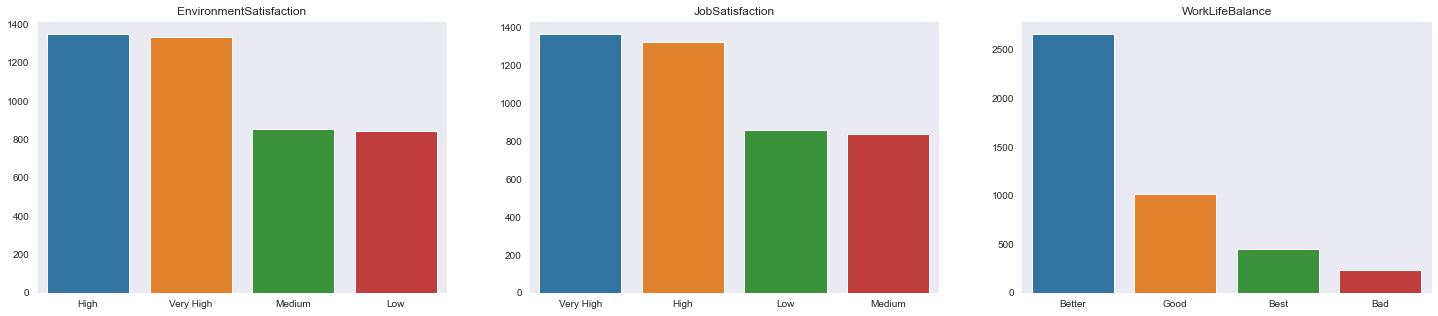

In [29]:
#Let's first deal with all the ordinal categorical variables that have missing values.
target_variables=["EnvironmentSatisfaction","JobSatisfaction","WorkLifeBalance"]

plt.figure(figsize=(25,5))
sns.set_style("dark")
for i,col_name in zip(range(1,4),target_variables):
    plt.subplot(1,3,i)
    sns.barplot(x=list(df[col_name].value_counts().index),y=list(df[col_name].value_counts().values))
    plt.title(col_name)
plt.show()

In [30]:
#Based on the bar plots above, the mode will be used to impute the null values in these 3 variables.
df["EnvironmentSatisfaction"].fillna("High",inplace=True)
df["JobSatisfaction"].fillna("Very High",inplace=True)
df["WorkLifeBalance"].fillna("Better",inplace=True)

<AxesSubplot:xlabel='TotalWorkingYears', ylabel='Density'>

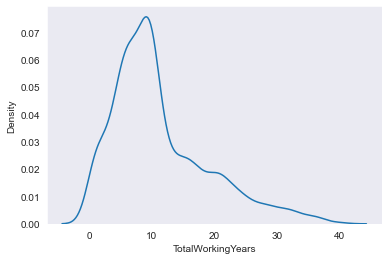

In [31]:
# Now let's deal with numerical variables that have missing values (NumCompaniesWorked and TotalWorkingYears) (NAN).
#Let's examine the distribution of TotalWorking Years.
sns.kdeplot(df["TotalWorkingYears"])

In [32]:
#Since the distribution is highly skewed to the right, it is best to use median to impute the missing values for TotalWorkingYears.
df.loc[df["TotalWorkingYears"].isnull(),"TotalWorkingYears"]=df.loc[:,"TotalWorkingYears"].median()

In [33]:
#When if an employee has worked less than a year, it can be assumed that he/she has worked for 1 company.
df.loc[df["TotalWorkingYears"]==0.0][["TotalWorkingYears","NumCompaniesWorked"]].head()

,TotalWorkingYears,NumCompaniesWorked
38,0.0,1.0
43,0.0,1.0
199,0.0,1.0
357,0.0,1.0
469,0.0,1.0


In [34]:
df.loc[(df["TotalWorkingYears"]==0.0)& (df["NumCompaniesWorked"].isnull()),"NumCompaniesWorked"]=1.0

<AxesSubplot:xlabel='NumCompaniesWorked', ylabel='Density'>

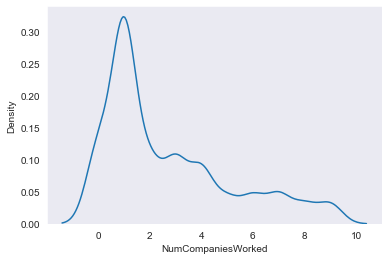

In [35]:
df[df["NumCompaniesWorked"].isnull()][["NumCompaniesWorked","YearsAtCompany","TotalWorkingYears"]]
#Examine the distribution of NumCompaniesWorked
sns.kdeplot(df["NumCompaniesWorked"])

In [36]:
#Just like TotalWorkingYears,the distribution of NumCompaniesWorked is skewed before I will impute the rest of the null values in NumCompaniesWorked using the medium.
df.loc[df["NumCompaniesWorked"].isnull(),"NumCompaniesWorked"]=df.loc[:,"NumCompaniesWorked"].median()

In [37]:
#Convert the data type for both NumCompaniesWorked and TotalWorkingYears to integer in order to save memory.
df["NumCompaniesWorked"]=df["NumCompaniesWorked"].astype("int64")
df["TotalWorkingYears"]=df["TotalWorkingYears"].astype("int64")

In [38]:
#Check if it makes sense to have zeros in non-binary numerical variables
non_binary_num_vars=list(df.dtypes[~((df.dtypes=="int8") | (df.dtypes=="category"))].index)
zeros={}
for col_name in non_binary_num_vars:
    num=len(df[df[col_name]==0])
    zeros[col_name]=num
zeros

{'Age': 0,
 'DistanceFromHome': 0,
 'MonthlyIncome': 0,
 'NumCompaniesWorked': 586,
 'PercentSalaryHike': 0,
 'TotalWorkingYears': 33,
 'TrainingTimesLastYear': 162,
 'YearsAtCompany': 132,
 'YearsSinceLastPromotion': 1743,
 'YearsWithCurrManager': 789}

In [39]:
df[df["NumCompaniesWorked"]==0][["NumCompaniesWorked","YearsAtCompany"]]
#It doesn't make sense for NumCompaniesWorked to be zero since all employees work for at least 1 company, and that is JWC.
#Impute the zero values with the medium
df.loc[df["NumCompaniesWorked"]==0,"NumCompaniesWorked"]=df.loc[:,"NumCompaniesWorked"].median()

## Feature Engineering

In [40]:
ordinal_vars=["Education","EnvironmentSatisfaction","JobInvolvement","PerformanceRating","WorkLifeBalance","JobSatisfaction"]
numerical_vars=list(df.dtypes[~((df.dtypes=="int8") | (df.dtypes=="category"))].index)
categorical_vars=[col for col in df.columns if col not in ordinal_vars+numerical_vars+["Attrition"]]
print(len(numerical_vars))
print(len(ordinal_vars))
print(len(categorical_vars))

10
6
7


### Numerical variables

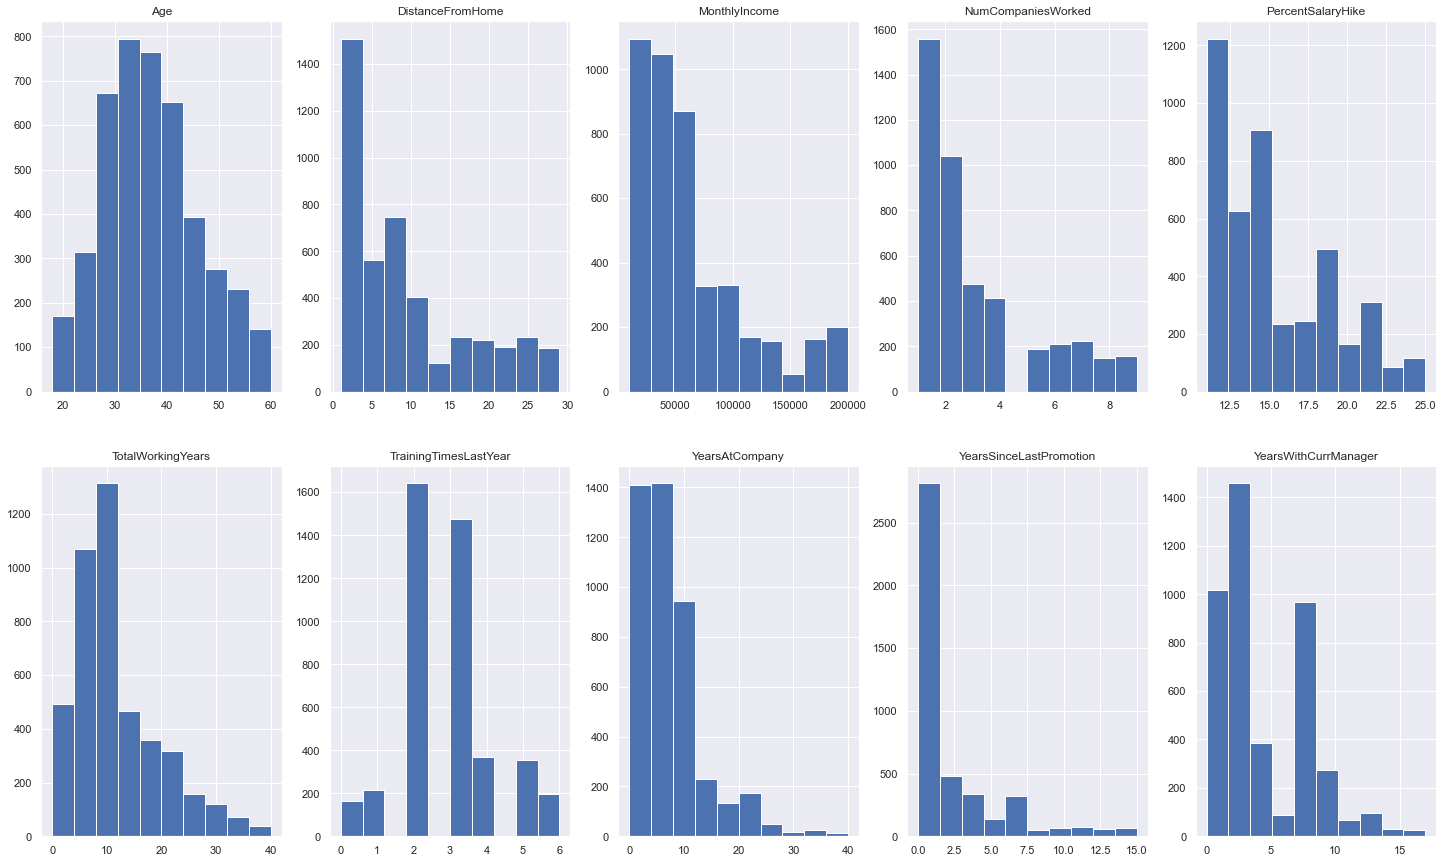

In [41]:
#let's examine the distribution of all the numercial variables
plt.figure(figsize=(25,15))
sns.set_theme()
for i,col_name in zip(range(1,11),numerical_vars):
    plt.subplot(2,5,i)
    plt.title(col_name)
    plt.hist(df[col_name])
#Based on the figure below, suggests that Age,TotalWorkingYears and TrainingTimesLastYear follow a normal distribution.
#The other variables follow a skewed distribition, specifically a positive skew.

##### Treatment of outliers

In [42]:
len(numerical_vars)

10

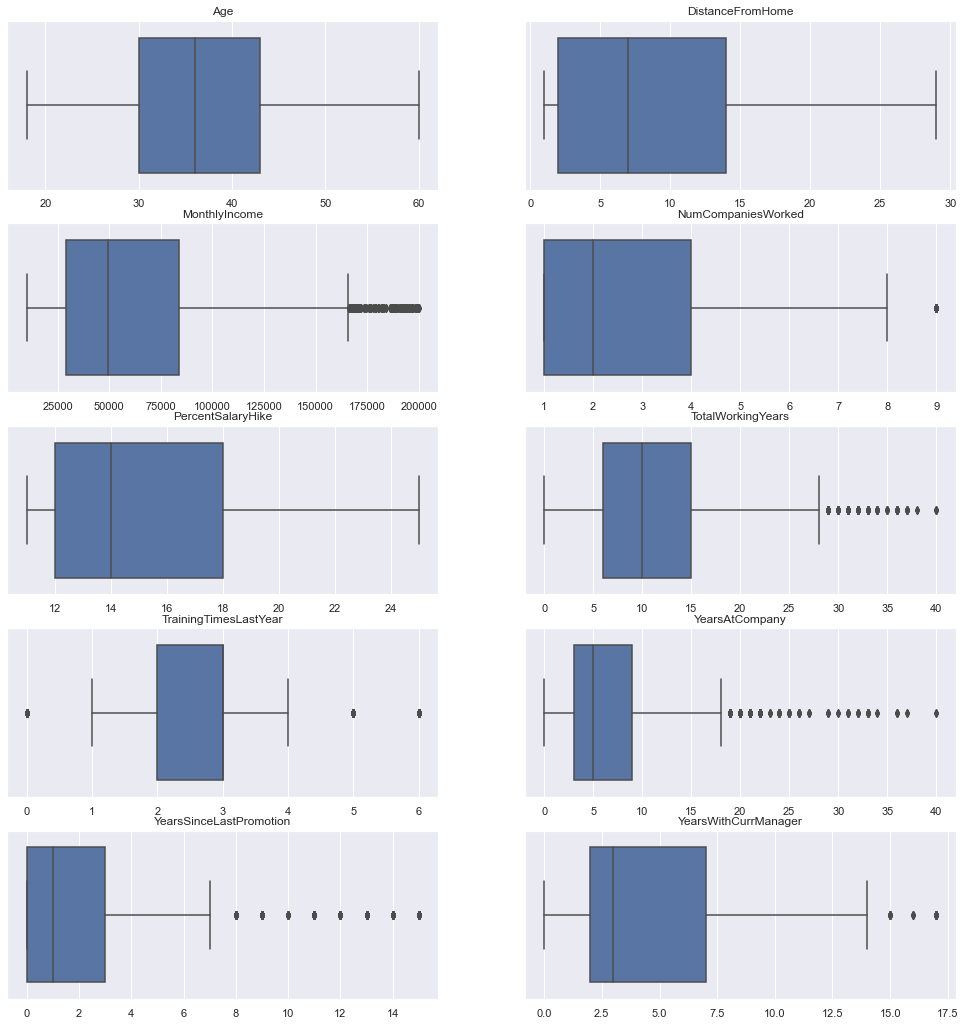

In [43]:
plt.figure(figsize=(17,18))
for i,col_name in zip(range(1,11),numerical_vars):
    plt.subplot(5,2,i)
    sns.boxplot(x=df[col_name],orient="h")
    plt.xlabel("")
    plt.title(col_name)

In [44]:
df.shape

(4410, 24)

In [45]:
#Remove as many outliers from the dataset through trial and error but also keeping as much data as possible.
max_q=df["NumCompaniesWorked"].quantile(.99)
df=df[df["NumCompaniesWorked"]<max_q]
max_q=df["YearsWithCurrManager"].quantile(.98)
df=df[df["YearsWithCurrManager"]<max_q]
max_q=df["MonthlyIncome"].quantile(0.87)
df=df[df["MonthlyIncome"]<max_q]
max_q=df["YearsAtCompany"].quantile(0.97)
df=df[df["YearsAtCompany"]<max_q]
max_q=df["YearsSinceLastPromotion"].quantile(0.95)
df=df[df["YearsSinceLastPromotion"]<max_q]
max_q=df["TotalWorkingYears"].quantile(0.98)
df=df[df["TotalWorkingYears"]<max_q]
min_q,max_q=df["TrainingTimesLastYear"].quantile([0.01,0.96])
df=df[(df["TrainingTimesLastYear"]<max_q) &(df["TrainingTimesLastYear"]>min_q)]

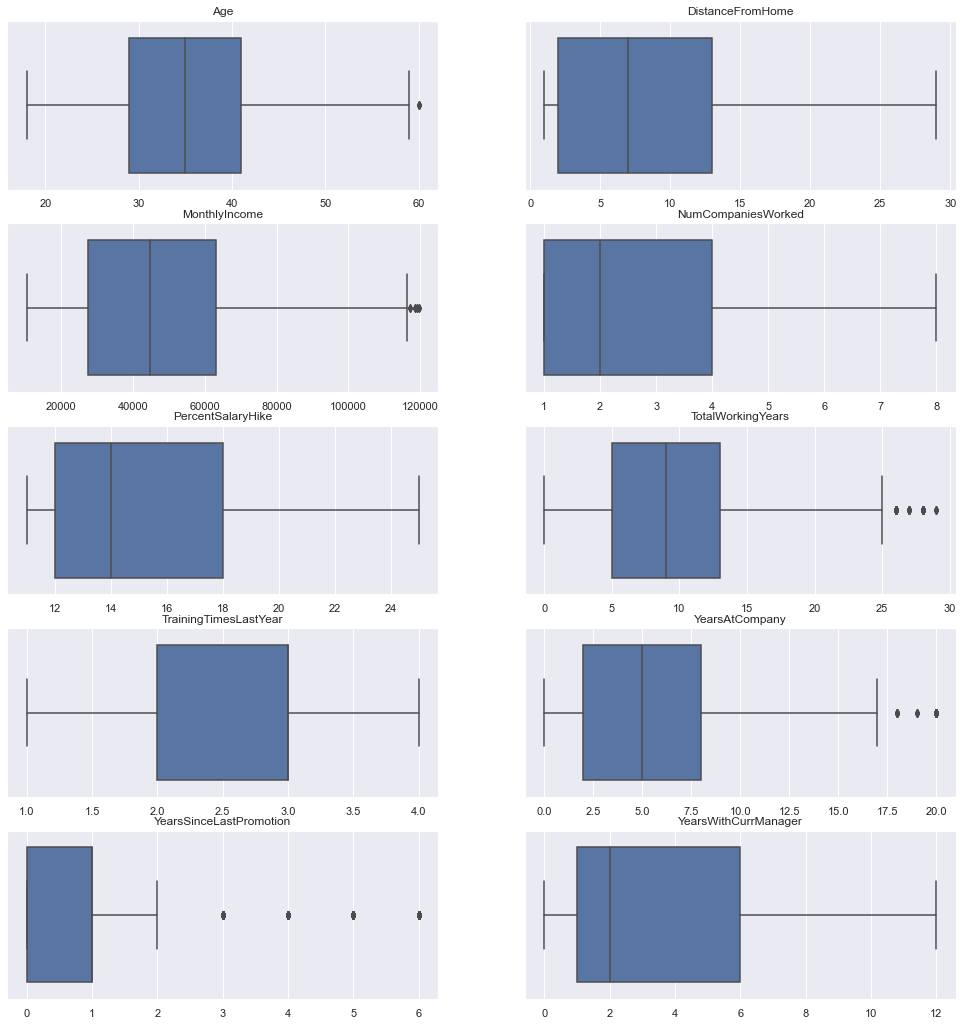

In [46]:
plt.figure(figsize=(17,18))
for i,col_name in zip(range(1,11),numerical_vars):
    plt.subplot(5,2,i)
    sns.boxplot(x=df[col_name],orient="h")
    plt.xlabel("")
    plt.title(col_name)

In [47]:
df.shape

(2601, 24)

#### Examine the relationship between the numerical variables and attrition rate (dependent variable)


In [48]:
#The numerical variables can be split into discreate and continuous variables
discrete_vars=[var for var in numerical_vars if len(df[var].unique())<25]
continuous_vars=[var for var in numerical_vars if var not in discrete_vars]
print(len(discrete_vars))
print(len(continuous_vars))

6
4


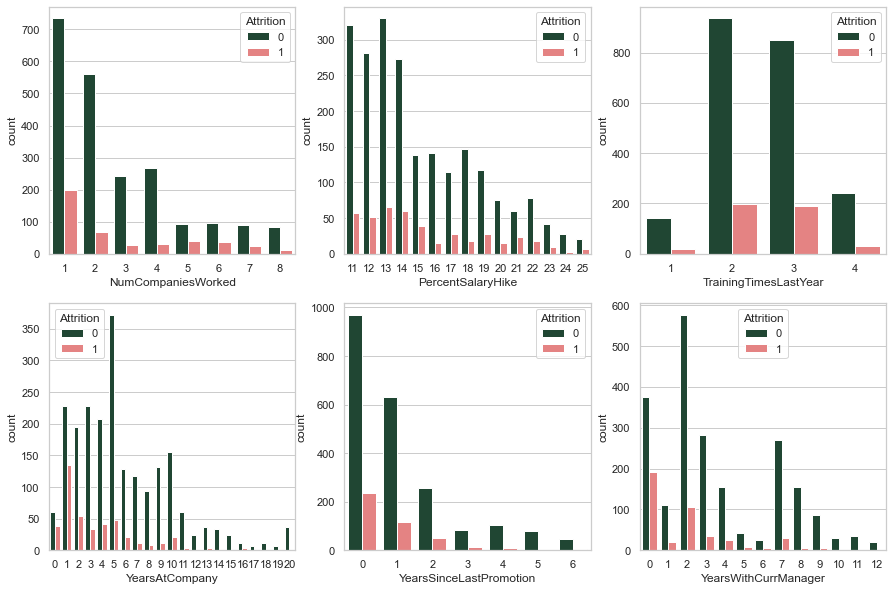

In [49]:
#Discrete variables
plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
for i,col_name in zip(range(1,7),discrete_vars):
    plt.subplot(2,3,i)
    sns.countplot(data=df,x=col_name,hue="Attrition",palette=["#194d33","#f47373"])
plt.show()

From the figure above, it is difficult to discern a clear relationship between the discrete variables and attrition. A possible negative relationship can be seen between percentsalaryhike and attrition. Perhaps, as the rate in which salary increases it reduces the number of employees who want to leave the company.

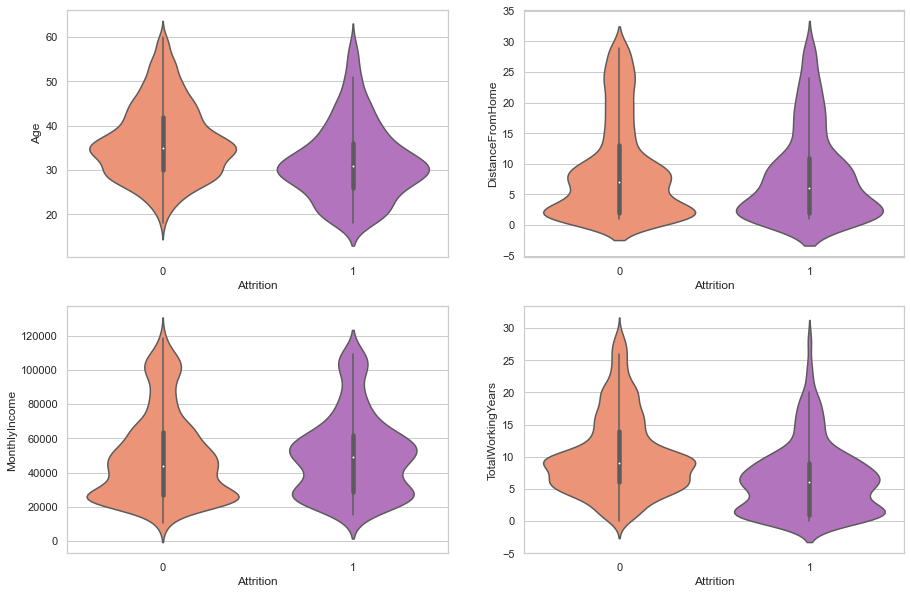

In [50]:
plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
for i,col_name in zip(range(1,5),continuous_vars):
    plt.subplot(2,2,i)
    sns.violinplot(x="Attrition",y=col_name,data=df,palette=["#ff8a65","#ba68c8"])
plt.show()


A few things to point out from the figure above:
1) Employees are more likely to leave the company around their 30s.

2) Distance travelled to work and total working years do not influence attrition.

3) Employees who earn between 23000 to 57000 monthly are more likely to leave a company.

##### Standardize the numerical variables

In [51]:
min_values={}
for col_name in numerical_vars:
    min_value=df[col_name].min()
    min_values[col_name]=min_value
min_values=pd.Series(min_values)
max_values={}
for col_name in numerical_vars:
    max_value=df[col_name].max()
    max_values[col_name]=max_value
max_values=pd.Series(max_values)

In [52]:
min_max=pd.concat([min_values,max_values],axis=1)
min_max.rename({0:"min",1:"max"},axis=1,inplace=True)
min_max

,min,max
Age,18,60
DistanceFromHome,1,29
MonthlyIncome,10510,119570
NumCompaniesWorked,1,8
PercentSalaryHike,11,25
TotalWorkingYears,0,29
TrainingTimesLastYear,1,4
YearsAtCompany,0,20
YearsSinceLastPromotion,0,6
YearsWithCurrManager,0,12


In [53]:
#Since the range is relatively large for all the numerical variables, so it is good to standardize the variables to reduce the fluctuation in the data.
scaler = StandardScaler()
df[numerical_vars] = scaler.fit_transform(df[numerical_vars])

### Categorical Variable

In [54]:
for var in ordinal_vars:
    print("The variable is {} and there are {} unique categories.".format(var,len(df[var].unique())))

The variable is Education and there are 5 unique categories.
The variable is EnvironmentSatisfaction and there are 4 unique categories.
The variable is JobInvolvement and there are 4 unique categories.
The variable is PerformanceRating and there are 2 unique categories.
The variable is WorkLifeBalance and there are 4 unique categories.
The variable is JobSatisfaction and there are 4 unique categories.


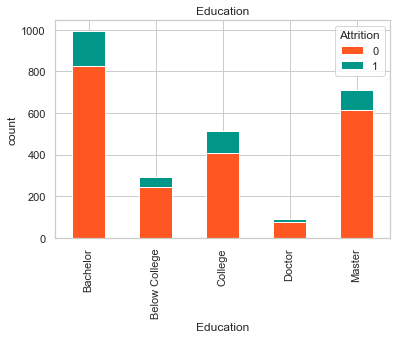

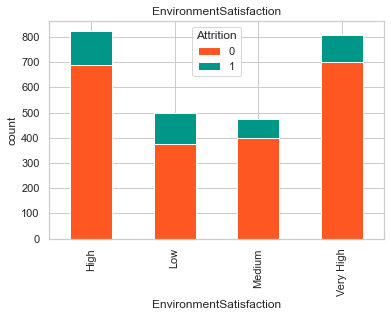

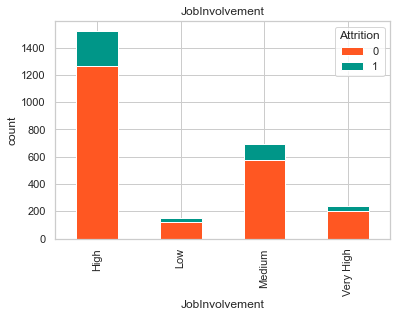

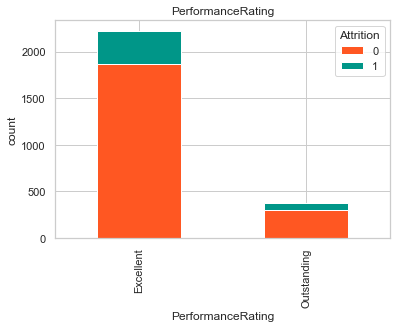

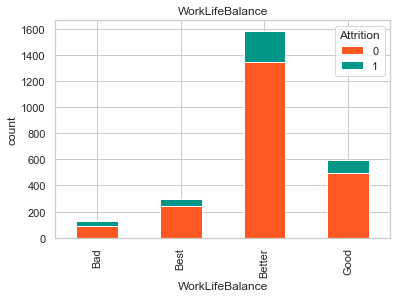

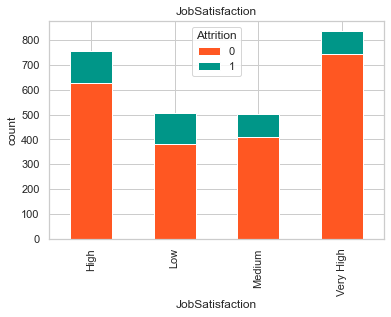

In [55]:
#Examine the relationship between the categorical variables and attrition.
for var in ordinal_vars:
    data=df.copy()
    a=data.groupby([var,"Attrition"])[var].count().unstack("Attrition")
    a[[0,1]].plot(kind="bar",stacked=True,color=["#ff5722","#009688"])
    plt.ylabel("count")
    plt.title(var)
    plt.show()

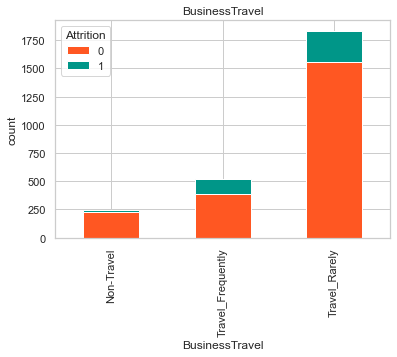

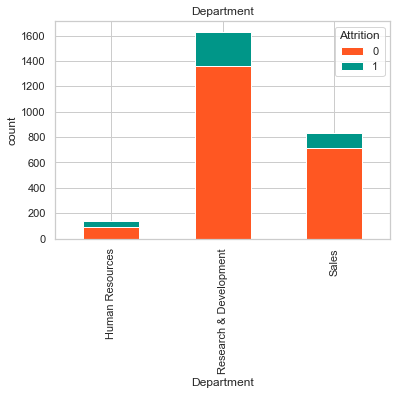

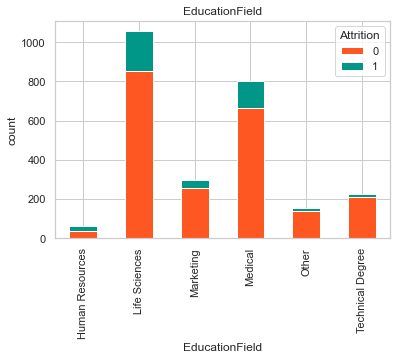

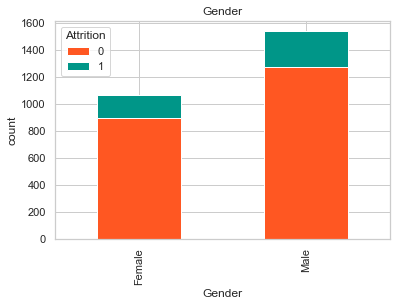

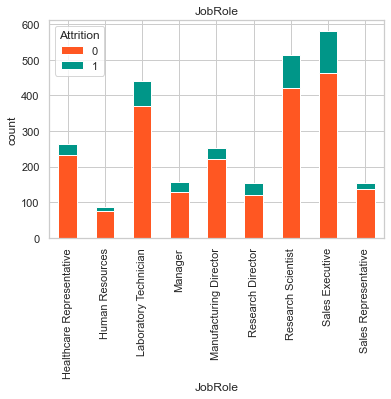

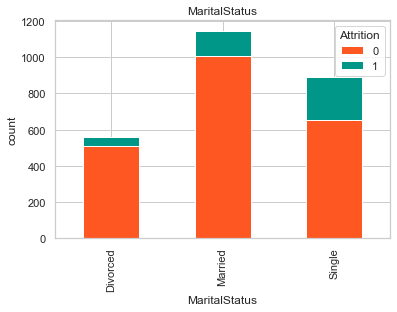

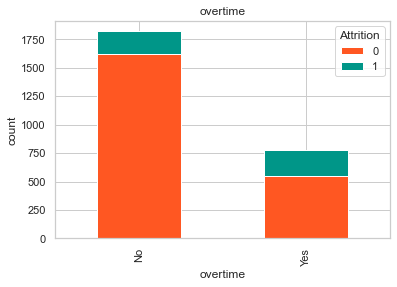

In [56]:
for var in categorical_vars:
    data=df.copy()
    a=data.groupby([var,"Attrition"])[var].count().unstack("Attrition")
    a[[0,1]].plot(kind="bar",stacked=True,color=["#ff5722","#009688"])
    plt.ylabel("count")
    plt.title(var)
    plt.show()

In [57]:
df.head()

,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,...,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,overtime
1,High,Medium,Best,-0.548662,1,Travel_Frequently,Research & Development,0.131059,Below College,Life Sciences,...,-0.383086,2.172641,-0.587274,0.597846,-0.104124,-0.057783,0.203901,Medium,Outstanding,No
4,Very High,Low,Better,-0.433175,0,Travel_Rarely,Research & Development,0.131059,Below College,Medical,...,0.614818,-0.880325,-0.105565,-0.717719,0.137254,-0.744061,0.203901,High,Excellent,Yes
6,Low,High,Bad,-0.895122,1,Travel_Rarely,Research & Development,0.257172,College,Medical,...,-0.383086,1.340014,-0.747844,-0.717719,-1.311016,-0.744061,-1.105595,High,Outstanding,No
7,Low,Medium,Better,-0.779636,0,Travel_Rarely,Research & Development,1.139965,Bachelor,Life Sciences,...,-0.383086,1.895099,0.055005,-0.717719,-1.311016,-0.744061,-1.105595,High,Outstanding,No
10,High,Very High,Better,1.068153,0,Travel_Rarely,Research & Development,1.013852,College,Medical,...,-0.383086,-0.602782,1.821272,-0.717719,3.516552,2.001050,2.168145,Medium,Excellent,Yes


##### Encoding

In [58]:
#ordinal encoding
df["Education"]=df["Education"].map({"Below College":1,"College":2,"Bachelor":3,"Master":4,"Doctor":5})
df["EnvironmentSatisfaction"]=df["EnvironmentSatisfaction"].map({"Low":1,"Medium":2,"High":3,"Very High":4})
df["JobInvolvement"]=df["JobInvolvement"].map({"Low":1,"Medium":2,"High":3,"Very High":4})
df["JobSatisfaction"]=df["JobSatisfaction"].map({"Low":1,"Medium":2,"High":3,"Very High":4})
df["PerformanceRating"]=df["PerformanceRating"].map({"Low":1,"Good":2,"Excellent":3,"Outstanding":4})
df["WorkLifeBalance"]=df["WorkLifeBalance"].map({"Bad":1,"Good":2,"Better":3,"Best":4})

In [59]:
#One-hot encoding
df1=pd.get_dummies(df[categorical_vars],drop_first=True)
df=pd.concat([df1,df],axis=1)
df.drop(categorical_vars,axis=1,inplace=True)

In [60]:
df.head()

,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,...,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating
1,1,0,1,0,1,0,0,0,0,0,...,-0.297131,-0.383086,2.172641,-0.587274,0.597846,-0.104124,-0.057783,0.203901,2,4
4,0,1,1,0,0,0,1,0,0,1,...,-1.025820,0.614818,-0.880325,-0.105565,-0.717719,0.137254,-0.744061,0.203901,3,3
6,0,1,1,0,0,0,1,0,0,1,...,0.343579,-0.383086,1.340014,-0.747844,-0.717719,-1.311016,-0.744061,-1.105595,3,4
7,0,1,1,0,1,0,0,0,0,1,...,-0.709805,-0.383086,1.895099,0.055005,-0.717719,-1.311016,-0.744061,-1.105595,3,4
10,0,1,1,0,0,0,1,0,0,1,...,1.202857,-0.383086,-0.602782,1.821272,-0.717719,3.516552,2.001050,2.168145,2,3


## Correlation analysis

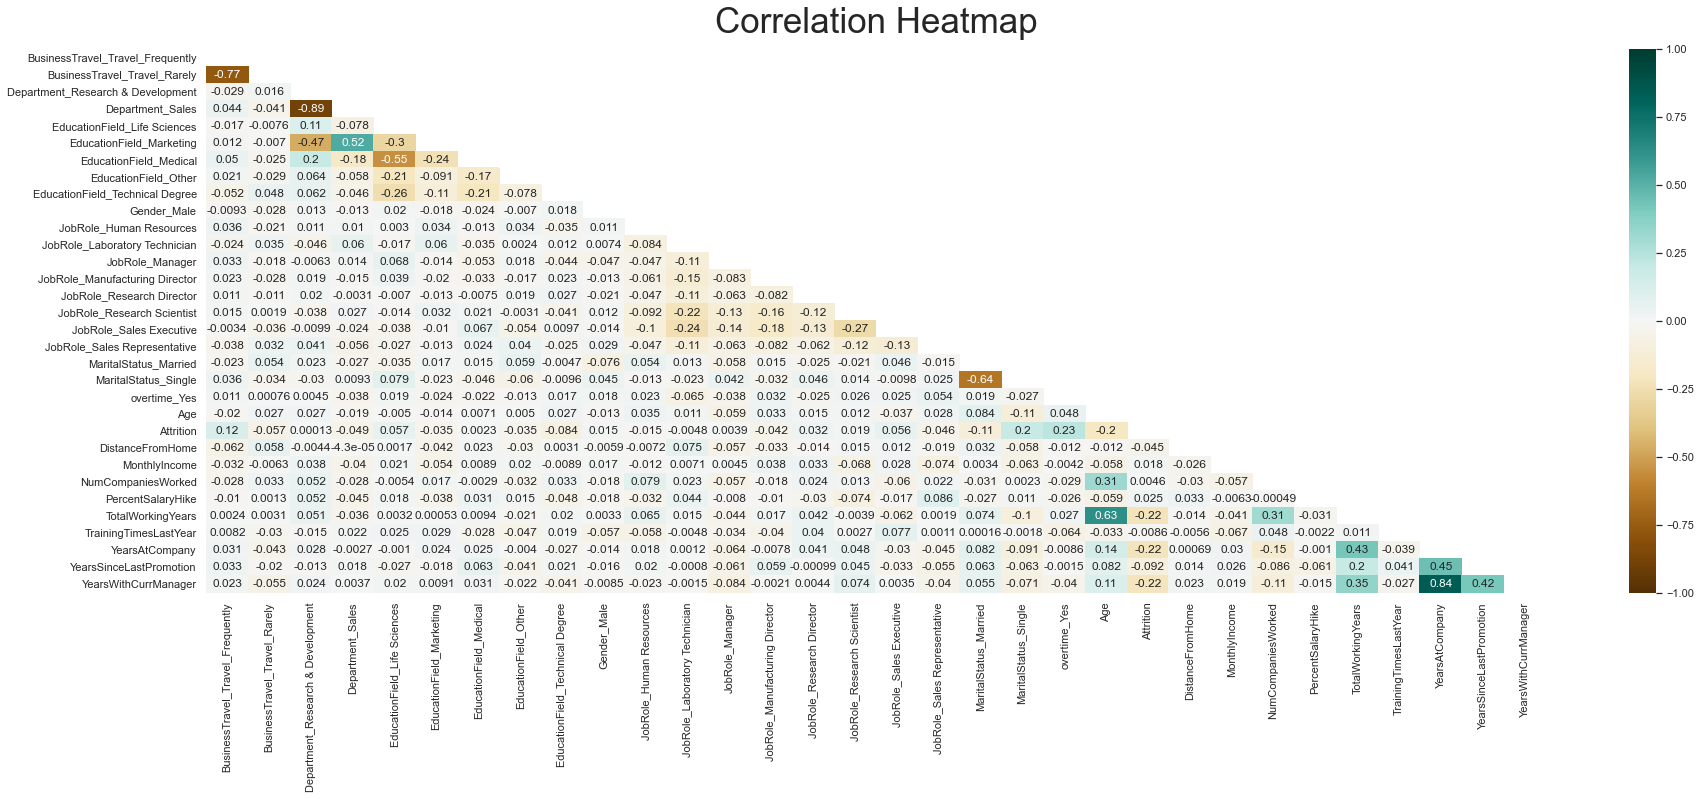

In [61]:
plt.figure(figsize=(30, 10))
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool_))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':35}, pad=16);

Looking at the figure above there are a few highly correlated variables:

Positive relationship:

    -YearsAtCompany ~ YearsWithCurrManager

Negative relationship:

    -BusinessTravel_Travel_Rarely ~ BusinessTravel_Travel_Frequently

    -Department_Sale ~ Department_Research & Development

#### Check for Multi-collinearity
The variance inflation factor can be used to check for multi-collinearity between the independent variables, and it also indicates which variables should be disgarded from our machine learning model.

In [62]:
def vif_score(x):
    return pd.DataFrame([[x.columns[i],variance_inflation_factor(x.values,i)]for i in range(x.shape[1])],columns=["Feature","VIF_SCORE"])

In [63]:
#split data in y and x
y=df["Attrition"]
x=df.drop(columns=["Attrition"])

In [64]:
vif_score(x)

,Feature,VIF_SCORE
0,BusinessTravel_Travel_Frequently,3.076329
1,BusinessTravel_Travel_Rarely,8.341888
2,Department_Research & Development,23.549050
3,Department_Sales,13.098330
4,EducationField_Life Sciences,30.710327
5,EducationField_Marketing,10.105362
6,EducationField_Medical,23.297620
7,EducationField_Other,5.408309
8,EducationField_Technical Degree,7.427302
9,Gender_Male,2.524125


##### Feature Elimination

In [65]:
condition=True
while condition:
    vif_df=vif_score(x)
    #7 is my chosen vif threshold value. Any variable that has a value above 7 will be removed from the model.
    if vif_df["VIF_SCORE"].max()>7:
        maxvif=vif_df["VIF_SCORE"].max()
        col_to_remove=list(vif_df[vif_df["VIF_SCORE"]==maxvif]["Feature"])[0]
        x.drop(col_to_remove,axis=1,inplace=True)
    else:
        condition=False  

In [66]:
vif_score(x)

,Feature,VIF_SCORE
0,BusinessTravel_Travel_Frequently,2.621348
1,BusinessTravel_Travel_Rarely,6.519300
2,Department_Sales,2.050193
3,EducationField_Marketing,1.703240
4,EducationField_Medical,1.718220
5,EducationField_Other,1.149536
6,EducationField_Technical Degree,1.214070
7,Gender_Male,2.323210
8,JobRole_Human Resources,1.316358
9,JobRole_Laboratory Technician,2.318402


## Data Modelling
The aim is to utilise a logistic regression model to predict JWC's attrition rate.

There are 2 main statistical models that can be used for predictive analysis when the dependent variable is dichotomous (variable that can take one of two values), and they are:

1) Logit regression model (logistic regression)

2) Probit regression model

These two models calculate the probability of an event occuring. 

The differentiating factor between the two models comes from the assumptions made on the distribution of the model's errors. The  logit model assumes a logistic distribution of errors, wheres that probit model assumes a normal distribution of errors.

### Implementation of the logit model

In [67]:
#train-test dataset
x_logit=x.copy()
y_logit=y.copy()
x_train_log,x_test_log,y_train_log,y_test_log=train_test_split(x_logit,y_logit,test_size=0.20,random_state=38)

In [68]:
#building the model and fitting the data
log_reg=sm.Logit(y_train_log,x_train_log).fit()

Optimization terminated successfully.
         Current function value: 0.314855
         Iterations 7


In [69]:
len(x_train_log.columns)

31

In [70]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 2080
Model:                          Logit   Df Residuals:                     2049
Method:                           MLE   Df Model:                           30
Date:                Thu, 08 Sep 2022   Pseudo R-squ.:                  0.3052
Time:                        16:36:54   Log-Likelihood:                -654.90
converged:                       True   LL-Null:                       -942.51
Covariance Type:            nonrobust   LLR p-value:                3.940e-102
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
BusinessTravel_Travel_Frequently     1.2388      0.271      4.574      0.000       0.708       1.770
BusinessTravel_Travel_Rarely         0.1869      0.235      0.796

From the above regression output, we see that there are a few statistically insignificant variables, meaning these variables do not have causal influence on the dependent variable. It might not be wise to remove all statistically insignificant variables at once, let's remove the most insignificant variable on at a time until all the remaining variables are significant.

In [71]:
def p_values_logit(x_train,y_train=y_train_log):
    log_reg=sm.Logit(y_train,x_train).fit()
    return pd.Series(log_reg.pvalues)

In [72]:
condition=True
while condition:
    p_values=p_values_logit(x_train_log)
    #set a signigicant value of 0.05
    if p_values.values.max()>0.05:
        col_to_remove=p_values.idxmax()
        x_train_log.drop(col_to_remove,axis=1,inplace=True)
        x_test_log.drop(col_to_remove,axis=1,inplace=True)
    else:
        condition=False  

Optimization terminated successfully.
         Current function value: 0.314855
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.314855
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.314870
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.314926
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.314950
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.315096
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.315211
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.315344
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.315595
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.315864
  

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\ProgramData\Anaconda3\lib

In [73]:
len(x_train_log.columns)

18

In [74]:
log_reg=sm.Logit(y_train_log,x_train_log).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.318157
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 2080
Model:                          Logit   Df Residuals:                     2062
Method:                           MLE   Df Model:                           17
Date:                Thu, 08 Sep 2022   Pseudo R-squ.:                  0.2979
Time:                        16:36:54   Log-Likelihood:                -661.77
converged:                       True   LL-Null:                       -942.51
Covariance Type:            nonrobust   LLR p-value:                1.995e-108
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
BusinessTravel_Travel_Frequently     1.0235      0.167      6.11

Now all the independent variables in our model are statistically significant! We have a parsimonious model :)

In [75]:
#performing predictions on the test dataset
y_pred_log=log_reg.predict(x_test_log)
y_pred_log=list(map(round,y_pred_log))

<AxesSubplot:>

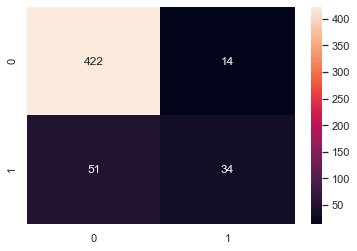

In [76]:
#Check the accuracy of the model
cm=confusion_matrix(y_test_log,y_pred_log)
sns.heatmap(cm,annot=True,fmt=".3g")

### Implementation of the probit model

In [77]:
#train-test dataset
x_probit=x.copy()
y_probit=y.copy()
x_train_pro,x_test_pro,y_train_pro,y_test_pro=train_test_split(x_probit,y_probit,test_size=0.20,random_state=38)

In [78]:
#building the model and fitting the data
pro_reg=Probit(y_train_pro,x_train_pro).fit()
print(pro_reg.summary())

Optimization terminated successfully.
         Current function value: 0.320753
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 2080
Model:                         Probit   Df Residuals:                     2049
Method:                           MLE   Df Model:                           30
Date:                Thu, 08 Sep 2022   Pseudo R-squ.:                  0.2921
Time:                        16:36:54   Log-Likelihood:                -667.17
converged:                       True   LL-Null:                       -942.51
Covariance Type:            nonrobust   LLR p-value:                 4.560e-97
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
BusinessTravel_Travel_Frequently     0.6399      0.149      4.30

In [79]:
def p_values_probit(x_train,y_train=y_train_pro):
    pro_reg=Probit(y_train,x_train).fit()
    return pd.Series(pro_reg.pvalues)

In [80]:
condition=True
while condition:
    p_values=p_values_probit(x_train_pro)
    #set a signigicant value of 0.05
    if p_values.values.max()>0.05:
        col_to_remove=p_values.idxmax()
        x_train_pro.drop(col_to_remove,axis=1,inplace=True)
        x_test_pro.drop(col_to_remove,axis=1,inplace=True)
    else:
        condition=False 

Optimization terminated successfully.
         Current function value: 0.320753
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.320753
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.320754
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.320800
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.320870
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.320979
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.321217
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.321426
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.321756
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.322054
  

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\ProgramData\Anaconda3\lib

In [81]:
pro_reg=Probit(y_train_pro,x_train_pro).fit()
print(pro_reg.summary())

Optimization terminated successfully.
         Current function value: 0.324448
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 2080
Model:                         Probit   Df Residuals:                     2062
Method:                           MLE   Df Model:                           17
Date:                Thu, 08 Sep 2022   Pseudo R-squ.:                  0.2840
Time:                        16:36:54   Log-Likelihood:                -674.85
converged:                       True   LL-Null:                       -942.51
Covariance Type:            nonrobust   LLR p-value:                6.730e-103
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
BusinessTravel_Travel_Frequently     0.5296      0.091      5.80

Looks like the same number of independent variables are removed in this model is the same as the logit model

In [82]:
#performing predictions on the test dataset
y_pred_pro=pro_reg.predict(x_test_pro)
y_pred_pro=list(map(round,y_pred_pro))

<AxesSubplot:>

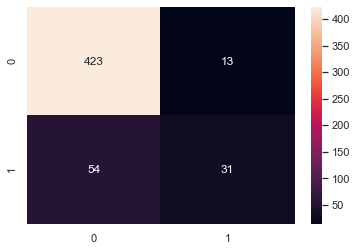

In [83]:
#Check the accuracy of the model
cm=confusion_matrix(y_test_pro,y_pred_pro)
sns.heatmap(cm,annot=True,fmt=".3g")

## Model evaluation

In [84]:
def model_eval(y_true,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
    accuracy=(tp+tn)/(tp+tn+fp+fn)
    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    specificity=tn/(fp+tn)
    F1_Score = 2*(recall * precision) / (recall + precision)
    result={"Accuracy":accuracy,"Precision":precision,"Recall":recall,'Specficity':specificity,'F1':F1_Score}
    return result

In [85]:
model_eval(y_test_log,y_pred_log)

{'Accuracy': 0.8752399232245681,
 'Precision': 0.7083333333333334,
 'Recall': 0.4,
 'Specficity': 0.9678899082568807,
 'F1': 0.5112781954887219}

In [86]:
model_eval(y_test_pro,y_pred_pro)

{'Accuracy': 0.8714011516314779,
 'Precision': 0.7045454545454546,
 'Recall': 0.36470588235294116,
 'Specficity': 0.9701834862385321,
 'F1': 0.48062015503875966}

There is a trade-off between precision and recall. Based on the business context, we would either one of the two metrics to judge the performance of your model. In this project, I think that precision should be chosen over recall because we want to minimise the number of employees we predict to be leaving the company (false positive).

Based on precision, the logit model is better than the probit model. This is backed up by the F1 score (calculated by taking the average between precision and recall).

In [87]:
#Further breakdown of the metrics
print(classification_report(y_test_log,y_pred_log))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       436
           1       0.71      0.40      0.51        85

    accuracy                           0.88       521
   macro avg       0.80      0.68      0.72       521
weighted avg       0.86      0.88      0.86       521



In [88]:
#Further breakdown of the metrics
print(classification_report(y_test_pro,y_pred_pro))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       436
           1       0.70      0.36      0.48        85

    accuracy                           0.87       521
   macro avg       0.80      0.67      0.70       521
weighted avg       0.86      0.87      0.85       521



Both models performed similarly in predicting employees that are not going to leave the company. However, the logit model is slightly better at predicting employees that are leaving.

#### ROC curves

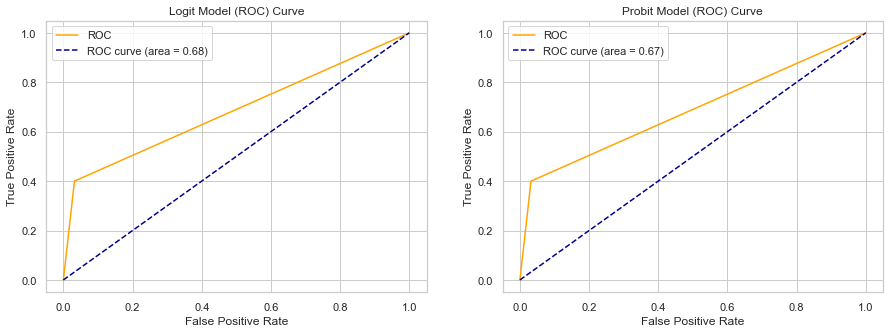

In [90]:
fpr, tpr, thresholds  = roc_curve(y_test_log,y_pred_log)
auc_log = roc_auc_score(y_test_log,y_pred_log)
auc_pro = roc_auc_score(y_test_pro,y_pred_pro)
auc_values=[("Logit",auc_log),("Probit",auc_pro)]
plt.figure(figsize=(15,5))
for i,auc_value in zip(range(1,3),auc_values):
    plt.subplot(1,2,i)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auc_value[1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(auc_value[0]+" Model (ROC) Curve")
    plt.legend()
plt.show()




The area under the ROC curve for the logit probit is greater than the probit model, confirming that the logit model is the better model.

Through some research, I've found that we cannot rely on machine learning measures as such ROC, precision and F1 to choose between a logit and probit model. 

According to this website, which talks about a research paper:
https://davegiles.blogspot.com/2016/06/choosing-between-logit-and-probit-models.html

If the dependent variable is unbalanced, we can use Akaike information criterion (AIC) as an effective metric to decide between a logit and probit model.

In [ ]:
#let's first check if the attrition variable is balance or not.
colors = sns.color_palette('pastel')[0:2]
plt.pie(y.value_counts(),labels=y.value_counts().index,colors=colors,autopct="%.0f%%")
plt.show()

Since, the dependent variable is heavily skewed we can use AIC, a statistical measure that evaluates how well a model fits the data.

In [ ]:
labels=("Logit","Probit")
y_pos=np.arange(len(labels))
aic_values=[log_reg.aic,pro_reg.aic]
plt.bar(y_pos, aic_values, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('AIC')
plt.title('AIC Comparison')
plt.show()



The lower the AIC value the better the fit of the model. Therefore, it again confirms that the logit model is better than the probit model.

Now, I'm going to illustrate which are the most important variables from the logit model. The following technique is based on this website, which I'm not sure about: 
https://sefiks.com/2021/01/06/feature-importance-in-logistic-regression/


In [ ]:
w=log_reg.params.values

In [ ]:
feature_importance=pd.DataFrame(log_reg.params.index,columns=["feature"])

In [ ]:
feature_importance["importance"]=pow(math.e,w)

In [ ]:
feature_importance.sort_values(by=["importance"],ascending=False)

From the table above, we can see that the top 3 factors that influence the attrition rate at JWC are:
1) Whether an employee works overtime or not.

2) Whether an employee is single.

3) Whether an employee travels frequently to work.